In [10]:
import os
import seaborn as sns
import neurokit2 as nk
import sklearn as sklearn
from scipy.stats import pearsonr, ttest_ind
from sklearn.neighbors import KNeighborsClassifier
import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
import graphviz 
import statsmodels.api as sm
from sklearn import tree
import xgboost as xgb
from sklearn.decomposition import PCA

import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from enum import IntEnum

In [2]:
class title_names(IntEnum):
    LABEL = 0,
    SUBJECT = 1,
    SIGNAL = 2,

class sensor_names(IntEnum):
    WRIST = 0,
    CHEST = 1,

class subject_state(IntEnum):
    TRANSIENT = 0,
    BASELINE  = 1,
    STRESSFUL = 2,
    AMUSEMENT = 3,
    MEDITATION = 4,


class read_data_of_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, subject): #(self, path, subject):
        #self.subject = subject
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        # os.chdir(path)
        # os.chdir(subject)
        with open(subject + '/' + subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data

    def get_labels(self):
        return self.data[self.keys[title_names.LABEL]]

    def get_wrist_data(self):
        """"""
        #label = self.data[self.keys[0]]
        #assert subject == self.data[self.keys[title_names.SUBJECT]]
        signal = self.data[self.keys[title_names.SIGNAL]]
        wrist_data = signal[self.signal_keys[sensor_names.WRIST]]
        return wrist_data

    def get_chest_data(self):
        """"""
        signal = self.data[self.keys[title_names.SIGNAL]]
        chest_data = signal[self.signal_keys[sensor_names.CHEST]]
        return chest_data
    
    
def extract_mean_std_features(ecg_data, label=0, block = 700):
    #print (len(ecg_data))
    i = 0
    mean_features = np.empty(int(len(ecg_data)/block), dtype=np.float64)
    std_features = np.empty(int(len(ecg_data)/block), dtype=np.float64)
    max_features = np.empty(int(len(ecg_data)/block), dtype=np.float64)
    min_features = np.empty(int(len(ecg_data)/block), dtype=np.float64)

    idx = 0
    while i < len(ecg_data):
        temp = ecg_data[i:i+block]
        #print(len(temp))
        if idx < int(len(ecg_data)/block):
            mean_features[idx] = np.mean(temp)
            std_features[idx] = np.std(temp)
            min_features[idx] = np.amin(temp)
            max_features[idx] = np.amax(temp)
        i += 700
        idx += 1
    #print(len(mean_features), len(std_features))
    #print(mean_features, std_features)
    features = {'mean':mean_features, 'std':std_features, 'min':min_features, 'max':max_features}

    one_set = np.column_stack((mean_features, std_features, min_features, max_features))
    return one_set

def extract_one(chest_data_dict, idx, l_condition=0):
    ecg_data = chest_data_dict["ECG"][idx].flatten()
    ecg_features = extract_mean_std_features(ecg_data, label=l_condition)
    #print(ecg_features.shape)

    eda_data = chest_data_dict["EDA"][idx].flatten()
    eda_features = extract_mean_std_features(eda_data, label=l_condition)
    #print(eda_features.shape)

    emg_data = chest_data_dict["EMG"][idx].flatten()
    emg_features = extract_mean_std_features(emg_data, label=l_condition)
    #print(emg_features.shape)

    temp_data = chest_data_dict["Temp"][idx].flatten()
    temp_features = extract_mean_std_features(temp_data, label=l_condition)
    #print(temp_features.shape)

    baseline_data = np.hstack((eda_features, temp_features, ecg_features, emg_features))
    #print(len(baseline_data))
    label_array = np.full(len(baseline_data), l_condition)
    #print(label_array.shape)
    #print(baseline_data.shape)
    baseline_data = np.column_stack((baseline_data, label_array))
    #print(baseline_data.shape)
    return baseline_data

def recur_print(ecg):
    while ecg is dict:
        print(ecg.keys())
        for k in ecg.keys():
            recur_print(ecg[k])

In [48]:
#Wrist dataset has not been captured properly, so it will not be used for our modals
# with open('S2/S2.pkl', 'rb') as f:
#     data = pickle.load(f, encoding='latin1')
#     print(np.mean(data['signal']['wrist']['BVP'][:,0]))
#     print(np.mean(data['signal']['wrist']['BVP'][:,0]))
subject_name = 'S5'
obj_data = {}
get = read_data_of_one_subject(subject_name)
chest_data_dict = get.get_chest_data()
wrist_data_dict = get.get_wrist_data()
chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
#wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}
print(chest_dict_length)
#print(wrist_dict_length)
#get labels
labels = get.get_labels()
baseline = np.asarray([idx for idx,val in enumerate(labels) if val == subject_state.BASELINE])
stressful = np.asarray([idx for idx,val in enumerate(labels) if val == subject_state.STRESSFUL])
print(baseline)
print(stressful)
print(labels[baseline])
print(labels[stressful])



{'ACC': 4380600, 'ECG': 4380600, 'EMG': 4380600, 'EDA': 4380600, 'Temp': 4380600, 'Resp': 4380600}
[ 195560  195561  195562 ... 1034157 1034158 1034159]
[2521660 2521661 2521662 ... 2973157 2973158 2973159]
[1 1 1 ... 1 1 1]
[2 2 2 ... 2 2 2]


In [26]:
# Firstly, just process the uncleaned data and see the output

bio_df_base, bio_info_base = nk.bio_process(ecg=chest_data_dict["ECG"][baseline].flatten(), 
                                  eda=chest_data_dict["EDA"][baseline].flatten(), sampling_rate=700)
bio_df_stress, bio_info_stress = nk.bio_process(ecg=chest_data_dict["ECG"][stressful].flatten(), 
                                  eda=chest_data_dict["EDA"][stressful].flatten(), sampling_rate=700)

print(bio_df_base.keys())
print()
print(bio_info_base.keys())

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_P_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular', 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic',
       'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude',
       'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')

dict_keys(['ECG_R_Peaks', 'SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'])


## Statistical Analysis


Covariance Matrix

ECG_Rate: 
[[1.         0.11072722]
 [0.11072722 1.        ]]
EDA_Tonic: 
[[ 1.         -0.78783359]
 [-0.78783359  1.        ]]
EDA_Phasic: 
[[1.00000000e+00 3.39456371e-04]
 [3.39456371e-04 1.00000000e+00]]


Mean of Heart-Rate
72.58454936019399
76.97027340922055

Mean of EDA_Tonic
2.056566935532588
1.7970950819394491

Mean of EDA_Phasic
-0.00012982885481698943
-2.907179050820325e-05

Standart Deviation
ECG_Rate-> base: 6.428933630054234, stress: 7.004470836337036
EDA_Tonic-> base: 1.0685821507338622, stress: 0.6117099421922108
EDA_Phasic-> base: 0.009949070600997086, stress: 0.039849422791361166


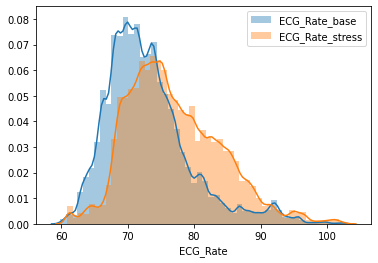

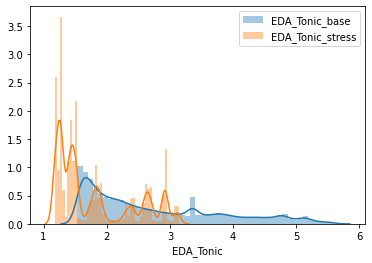

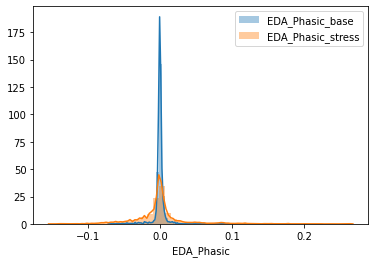


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-268.8512163809217, pvalue=0.0)
Pearsonr result (r,p): (0.11072721617168328, 0.0)
EDA_Tonic
Ttest_indResult(statistic=499.9616646335949, pvalue=0.0)
Pearsonr result (r,p): (-0.7878335908330275, 0.0)
EDA_Phasic
Ttest_indResult(statistic=-3.4250381732035704, pvalue=0.0006147416907146505)
Pearsonr result (r,p): (0.00033945637095531694, 0.8237494131504667)


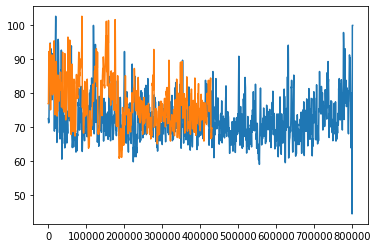

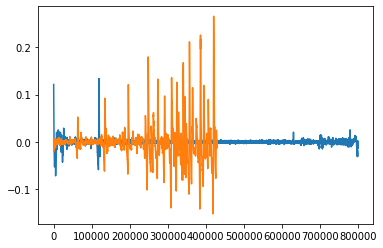

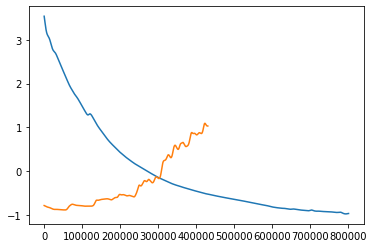

In [46]:
#ECG -> heart rate analysis with uncleaned data
#Heart-rate variability will not be considered due to shape differences

lb = len(bio_df_base["ECG_Rate"])
ls = len(bio_df_stress["ECG_Rate"])
#print(len(bio_df_base["ECG_Rate"])) # heart - rate
#print(len(bio_df_stress["ECG_Rate"]))

#display(bio_info_base["ECG_R_Peaks"][1:])
#display(bio_info_base["ECG_R_Peaks"][0:len(bio_info_base["ECG_R_Peaks"])-1])
#print(bio_df_stress["ECG_R_Peaks"].shape) # heart - rate

# heart-rate to heart-rate variability conversion 
#hrv_base   = bio_info_base["ECG_R_Peaks"][1:] - bio_info_base["ECG_R_Peaks"][0:len(bio_info_base["ECG_R_Peaks"])-1] + 1
#hrv_stress = bio_info_stress["ECG_R_Peaks"][1:] - bio_info_stress["ECG_R_Peaks"][0:len(bio_info_stress["ECG_R_Peaks"])-1] + 1 

#index_to_ms = 1000/700 # 700Hz 
#hrv_base = hrv_base *index_to_ms
#hrv_stress = hrv_stress * index_to_ms


#hrv_base = np.append(hrv_base, [hrv_base[-1],hrv_base[-1]])
#hrv_total = np.empty(shape=[ls+lb])
#hrv_total = []
#r_indx = 0
#prev_val = 0
#for val in bio_info_base["ECG_R_Peaks"]:    
#    hrv_total.append(np.linspace(hrv_base[r_indx], hrv_base[r_indx+1], num = val-prev_val))
#    r_indx += 1
#    prev_val = val


#print(hrv_base.shape) 
#print(hrv_stress.shape) 
#display(hrv_base[:60])
#display(hrv_stress[:60])
#print(np.mean(hrv_base))
#print(np.mean(hrv_stress))

#print(hrv_base.shape)
#print(hrv_stress.shape)
#corelation between stressed and baseline condition
print("\nCovariance Matrix\n")
print("ECG_Rate: \n{}".format(np.corrcoef(bio_df_base["ECG_Rate"][:ls], bio_df_stress["ECG_Rate"][:ls])))
print("EDA_Tonic: \n{}".format(np.corrcoef(bio_df_base["EDA_Tonic"][:ls], bio_df_stress["EDA_Tonic"][:ls])))
print("EDA_Phasic: \n{}".format(np.corrcoef(bio_df_base["EDA_Phasic"][:ls], bio_df_stress["EDA_Phasic"][:ls])))
print("\n")
print("Mean of Heart-Rate") 
print(np.mean(bio_df_base["ECG_Rate"]))
print(np.mean(bio_df_stress["ECG_Rate"]))
print("\nMean of EDA_Tonic")
print(np.mean(bio_df_base["EDA_Tonic"]))
print(np.mean(bio_df_stress["EDA_Tonic"]))
print("\nMean of EDA_Phasic")
print(np.mean(bio_df_base["EDA_Phasic"]))
print(np.mean(bio_df_stress["EDA_Phasic"]))
print("\nStandart Deviation")
print("ECG_Rate-> base: {}, stress: {}".format(bio_df_base["ECG_Rate"][:ls].std(),bio_df_stress["ECG_Rate"][:ls].std() ))
print("EDA_Tonic-> base: {}, stress: {}".format(bio_df_base["EDA_Tonic"][:ls].std(),bio_df_stress["EDA_Tonic"][:ls].std() ))
print("EDA_Phasic-> base: {}, stress: {}".format(bio_df_base["EDA_Phasic"][:ls].std(),bio_df_stress["EDA_Phasic"][:ls].std() ))

#distribution graph
sns.distplot(bio_df_base["ECG_Rate"][:ls], label='ECG_Rate_base')
sns.distplot(bio_df_stress["ECG_Rate"][:ls], label='ECG_Rate_stress')
plt.legend()
plt.show()

sns.distplot(bio_df_base["EDA_Tonic"][:ls], label='EDA_Tonic_base')
sns.distplot(bio_df_stress["EDA_Tonic"][:ls], label='EDA_Tonic_stress')
plt.legend()
plt.show()

sns.distplot(bio_df_base["EDA_Phasic"][:ls], label='EDA_Phasic_base')
sns.distplot(bio_df_stress["EDA_Phasic"][:ls], label='EDA_Phasic_stress')
plt.legend()
plt.show()

#Correlation
print("\nCorrelation tests")
print("ECG_Rate")
print(ttest_ind(bio_df_base["ECG_Rate"][:ls], bio_df_stress["ECG_Rate"][:ls]))
print("Pearsonr result (r,p): {}".format(pearsonr(bio_df_base["ECG_Rate"][:ls], bio_df_stress["ECG_Rate"][:ls])))
print("EDA_Tonic")
print(ttest_ind(bio_df_base["EDA_Tonic"][:ls], bio_df_stress["EDA_Tonic"][:ls]))
print("Pearsonr result (r,p): {}".format(pearsonr(bio_df_base["EDA_Tonic"][:ls], bio_df_stress["EDA_Tonic"][:ls])))
print("EDA_Phasic")
print(ttest_ind(bio_df_base["EDA_Phasic"][:ls], bio_df_stress["EDA_Phasic"][:ls]))
print("Pearsonr result (r,p): {}".format(pearsonr(bio_df_base["EDA_Phasic"][:ls], bio_df_stress["EDA_Phasic"][:ls])))

plt.plot(bio_df_base["ECG_Rate"])
plt.plot(bio_df_stress["ECG_Rate"])
plt.show()

plt.plot(bio_df_base["EDA_Phasic"])
plt.plot(bio_df_stress["EDA_Phasic"])
plt.show()
mean_eda_tonic = np.mean(bio_df_base["EDA_Tonic"])
plt.plot(bio_df_base["EDA_Tonic"] - mean_eda_tonic)
plt.plot(bio_df_stress["EDA_Tonic"] - mean_eda_tonic)
plt.show()


## Analyse all the participants' dataset


------------------------------------------

Analysis of subject S2 

{'ACC': 4255300, 'ECG': 4255300, 'EMG': 4255300, 'EDA': 4255300, 'Temp': 4255300, 'Resp': 4255300}
bio_process...
800800
430500

Covariance Matrix

ECG_Rate: 
[[1.         0.11072722]
 [0.11072722 1.        ]]
EDA_Tonic: 
[[ 1.         -0.78783359]
 [-0.78783359  1.        ]]
EDA_Phasic: 
[[1.00000000e+00 3.39456371e-04]
 [3.39456371e-04 1.00000000e+00]]


Mean of Heart-Rate
72.58454936019399
76.97027340922055

Mean of EDA_Tonic
2.056566935532588
1.7970950819394491

Mean of EDA_Phasic
-0.00012982885481698943
-2.907179050820325e-05

Standart Deviation
ECG_Rate-> base: 6.428933630054234, stress: 7.004470836337036
EDA_Tonic-> base: 1.0685821507338622, stress: 0.6117099421922108
EDA_Phasic-> base: 0.009949070600997086, stress: 0.039849422791361166


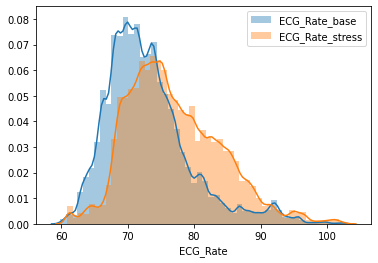

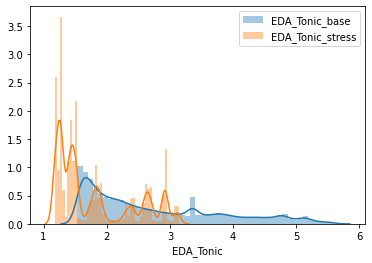

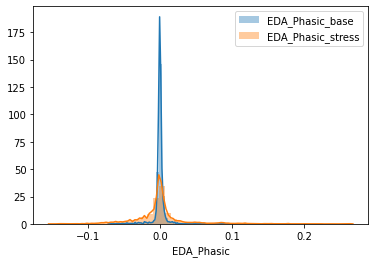


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-268.8512163809217, pvalue=0.0)
Pearsonr result (r,p): (0.11072721617168328, 0.0)
EDA_Tonic
Ttest_indResult(statistic=499.9616646335949, pvalue=0.0)
Pearsonr result (r,p): (-0.7878335908330275, 0.0)
EDA_Phasic
Ttest_indResult(statistic=-3.4250381732035704, pvalue=0.0006147416907146505)
Pearsonr result (r,p): (0.00033945637095531694, 0.8237494131504667)


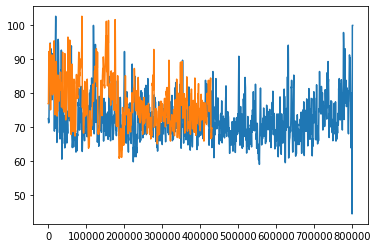

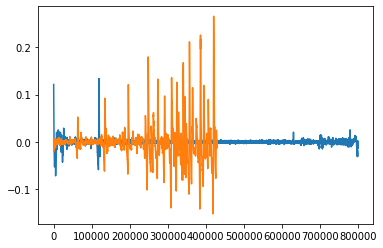

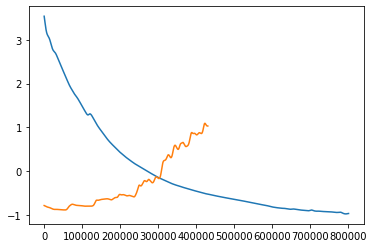


------------------------------------------

Analysis of subject S3 

{'ACC': 4545100, 'ECG': 4545100, 'EMG': 4545100, 'EDA': 4545100, 'Temp': 4545100, 'Resp': 4545100}
bio_process...
798000
448000

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.02915224]
 [-0.02915224  1.        ]]
EDA_Tonic: 
[[1.         0.11797493]
 [0.11797493 1.        ]]
EDA_Phasic: 
[[1.         0.01697326]
 [0.01697326 1.        ]]


Mean of Heart-Rate
54.440078681565176
86.67086241237415

Mean of EDA_Tonic
6.979973054768836
8.35791016633459

Mean of EDA_Phasic
-6.375758430591456e-05
-7.52442893814502e-06

Standart Deviation
ECG_Rate-> base: 6.593567641732995, stress: 16.577328902939634
EDA_Tonic-> base: 0.6922394541608293, stress: 1.0185535732412017
EDA_Phasic-> base: 0.015506898589386796, stress: 0.1319139571050933


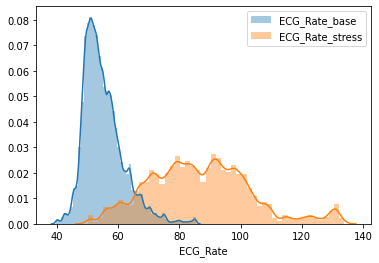

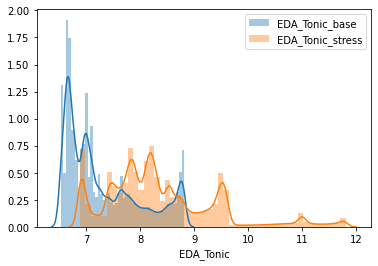

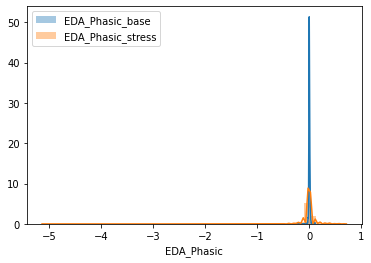


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-1181.0939851813273, pvalue=0.0)
Pearsonr result (r,p): (-0.02915223609270589, 7.949865561534725e-85)
EDA_Tonic
Ttest_indResult(statistic=-574.4671796640142, pvalue=0.0)
Pearsonr result (r,p): (0.11797492809862284, 0.0)
EDA_Phasic
Ttest_indResult(statistic=-0.5084998117651428, pvalue=0.6111029962709321)
Pearsonr result (r,p): (0.016973259881055292, 6.504453033481615e-30)


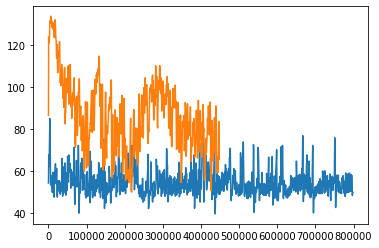

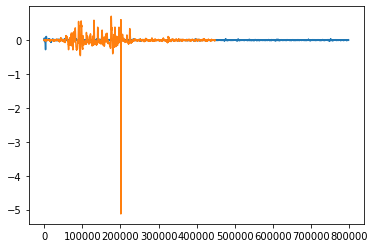

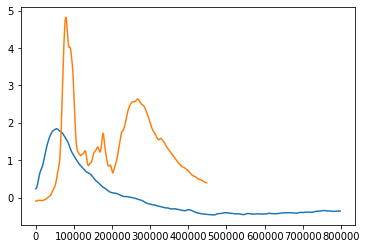


------------------------------------------

Analysis of subject S4 

{'ACC': 4496100, 'ECG': 4496100, 'EMG': 4496100, 'EDA': 4496100, 'Temp': 4496100, 'Resp': 4496100}
bio_process...
810601
444500

Covariance Matrix

ECG_Rate: 
[[1.         0.06725531]
 [0.06725531 1.        ]]
EDA_Tonic: 
[[1.         0.07656088]
 [0.07656088 1.        ]]
EDA_Phasic: 
[[1.        0.0734771]
 [0.0734771 1.       ]]


Mean of Heart-Rate
60.56780038468113
79.6375714292306

Mean of EDA_Tonic
1.2792761829225296
4.0938353312562805

Mean of EDA_Phasic
-7.285067886988032e-05
-0.00013964053429634893

Standart Deviation
ECG_Rate-> base: 6.359031940849364, stress: 8.842576830625328
EDA_Tonic-> base: 0.008248480734862446, stress: 0.6811184866282122
EDA_Phasic-> base: 0.002790406584840217, stress: 0.08289032553270546


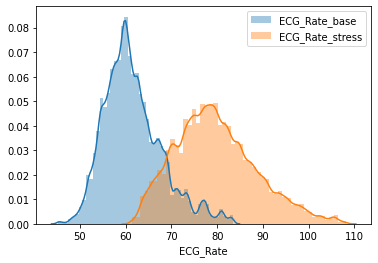

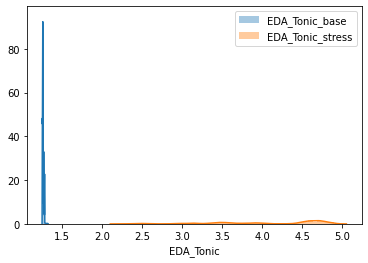

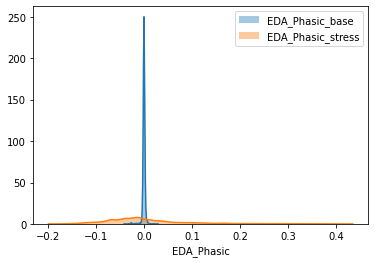


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-1106.4648801460955, pvalue=0.0)
Pearsonr result (r,p): (0.06725530567322825, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-2772.702882436501, pvalue=0.0)
Pearsonr result (r,p): (0.07656087882313528, 0.0)
EDA_Phasic
Ttest_indResult(statistic=0.05913414666193011, pvalue=0.9528452744074853)
Pearsonr result (r,p): (0.07347710053535426, 0.0)


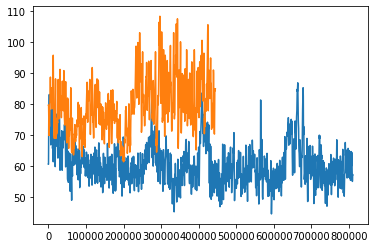

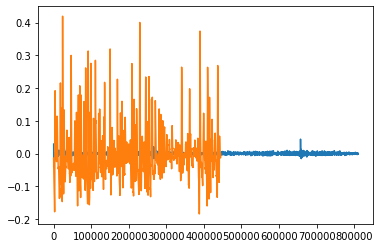

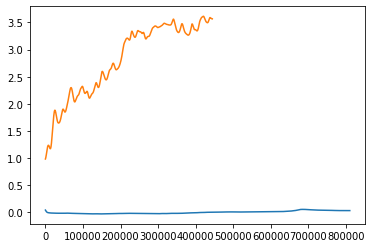


------------------------------------------

Analysis of subject S5 

{'ACC': 4380600, 'ECG': 4380600, 'EMG': 4380600, 'EDA': 4380600, 'Temp': 4380600, 'Resp': 4380600}
bio_process...
838600
451500

Covariance Matrix

ECG_Rate: 
[[1.         0.06922029]
 [0.06922029 1.        ]]
EDA_Tonic: 
[[1.         0.09511285]
 [0.09511285 1.        ]]
EDA_Phasic: 
[[ 1.         -0.00842867]
 [-0.00842867  1.        ]]


Mean of Heart-Rate
62.83606853073473
89.69946806004161

Mean of EDA_Tonic
4.091701484082989
9.610933648222423

Mean of EDA_Phasic
-6.72005789170949e-07
-7.161452766945205e-05

Standart Deviation
ECG_Rate-> base: 3.5728001312978903, stress: 7.366491485885877
EDA_Tonic-> base: 0.7115734743602771, stress: 0.37519380366758004
EDA_Phasic-> base: 0.016580031567898623, stress: 0.14401610782857457


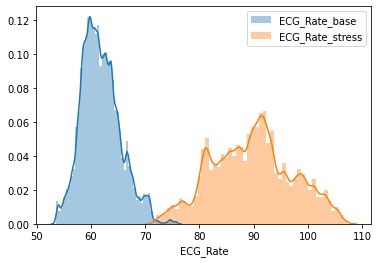

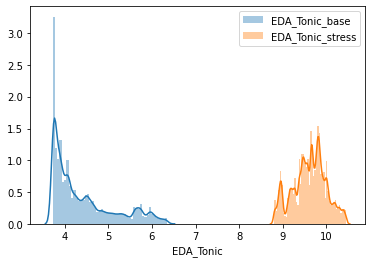

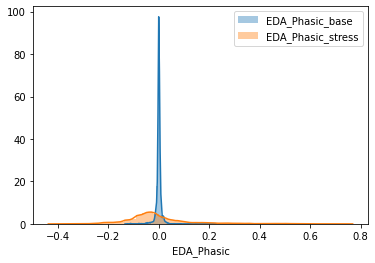


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-2288.1464646325617, pvalue=0.0)
Pearsonr result (r,p): (0.06922029160326308, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-4340.256891111149, pvalue=0.0)
Pearsonr result (r,p): (0.09511285147130455, 0.0)
EDA_Phasic
Ttest_indResult(statistic=0.3751289621117434, pvalue=0.7075646466417117)
Pearsonr result (r,p): (-0.008428671732248311, 1.4820768323425804e-08)


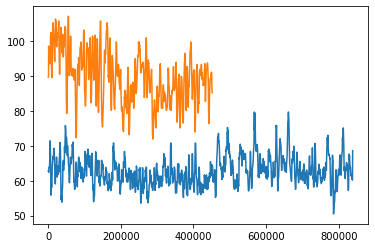

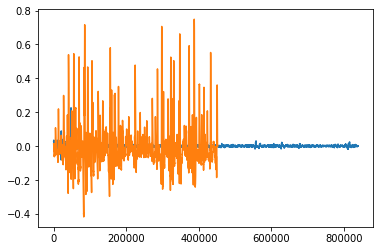

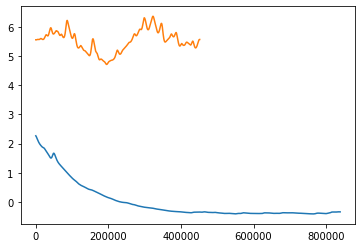


------------------------------------------

Analysis of subject S6 

{'ACC': 4949700, 'ECG': 4949700, 'EMG': 4949700, 'EDA': 4949700, 'Temp': 4949700, 'Resp': 4949700}
bio_process...
826000
455000

Covariance Matrix

ECG_Rate: 
[[1.        0.0949338]
 [0.0949338 1.       ]]
EDA_Tonic: 
[[ 1.         -0.65361308]
 [-0.65361308  1.        ]]
EDA_Phasic: 
[[1.         0.04933161]
 [0.04933161 1.        ]]


Mean of Heart-Rate
69.23948234015515
78.61708334860694

Mean of EDA_Tonic
6.835112399690499
9.319822997221754

Mean of EDA_Phasic
-1.6961874118679256e-06
0.0001840298201181577

Standart Deviation
ECG_Rate-> base: 4.437797918989833, stress: 8.178255623092555
EDA_Tonic-> base: 0.9839837022121011, stress: 0.9904175423570949
EDA_Phasic-> base: 0.007822239686962749, stress: 0.08821503367298819


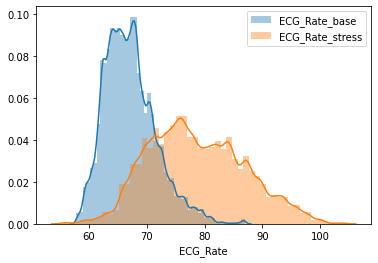

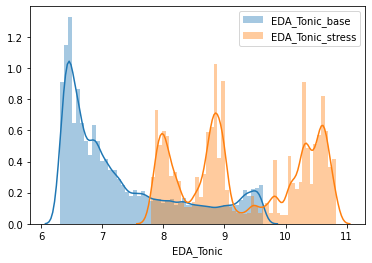

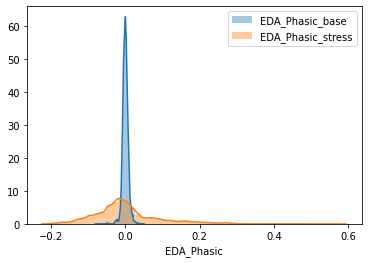


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-830.7472767118044, pvalue=0.0)
Pearsonr result (r,p): (0.09493379846542689, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-961.7840100845971, pvalue=0.0)
Pearsonr result (r,p): (-0.6536130774286397, 0.0)
EDA_Phasic
Ttest_indResult(statistic=-1.5743469479490808, pvalue=0.1154076091976818)
Pearsonr result (r,p): (0.04933161436792252, 4.3861672047300016e-243)


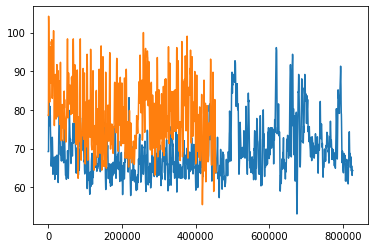

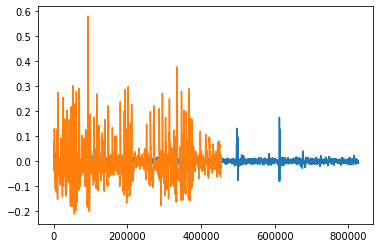

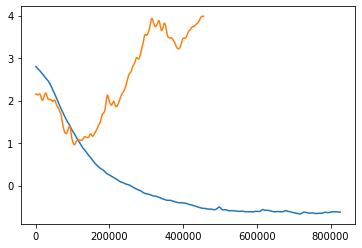


------------------------------------------

Analysis of subject S7 

{'ACC': 3666600, 'ECG': 3666600, 'EMG': 3666600, 'EDA': 3666600, 'Temp': 3666600, 'Resp': 3666600}
bio_process...
830200
448000

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.03371103]
 [-0.03371103  1.        ]]
EDA_Tonic: 
[[ 1.         -0.95415012]
 [-0.95415012  1.        ]]
EDA_Phasic: 
[[1.        0.0225411]
 [0.0225411 1.       ]]


Mean of Heart-Rate
70.58923354964266
85.70933901736878

Mean of EDA_Tonic
11.500864327936467
18.069922659979195

Mean of EDA_Phasic
-2.6998593169041355e-07
-4.468587419719123e-05

Standart Deviation
ECG_Rate-> base: 8.212846224476253, stress: 16.83863118100113
EDA_Tonic-> base: 0.5321843580902607, stress: 1.4843304714641736
EDA_Phasic-> base: 0.009633213880560333, stress: 0.07091400350117776


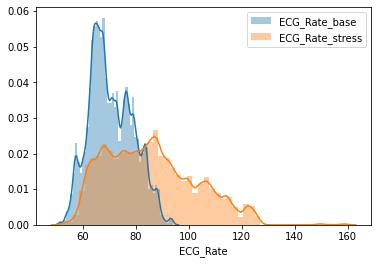

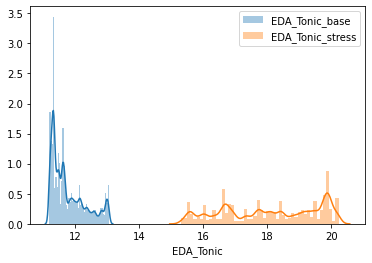

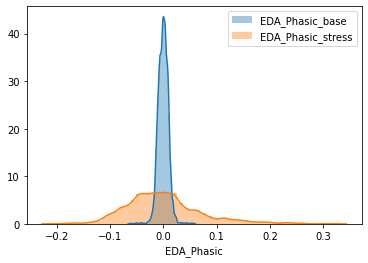


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-532.2306874741317, pvalue=0.0)
Pearsonr result (r,p): (-0.033711026596966585, 8.527946943128616e-113)
EDA_Tonic
Ttest_indResult(statistic=-2673.9286671520276, pvalue=0.0)
Pearsonr result (r,p): (-0.9541501222939485, 0.0)
EDA_Phasic
Ttest_indResult(statistic=0.39842405613238885, pvalue=0.6903177233050162)
Pearsonr result (r,p): (0.022541104970784532, 1.9054420217383062e-51)


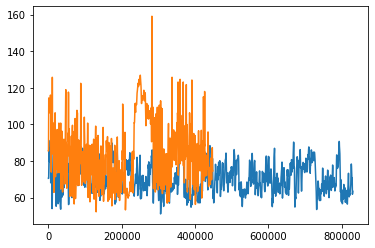

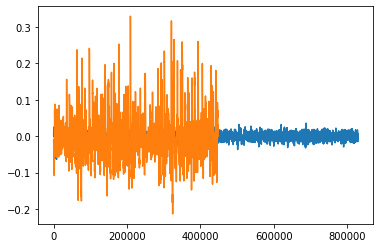

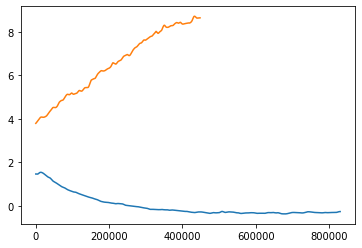


------------------------------------------

Analysis of subject S8 

{'ACC': 3826200, 'ECG': 3826200, 'EMG': 3826200, 'EDA': 3826200, 'Temp': 3826200, 'Resp': 3826200}
bio_process...
818300
469000

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.02088667]
 [-0.02088667  1.        ]]
EDA_Tonic: 
[[ 1.         -0.72982039]
 [-0.72982039  1.        ]]
EDA_Phasic: 
[[1.         0.02443246]
 [0.02443246 1.        ]]


Mean of Heart-Rate
70.81264857199292
91.23869371663221

Mean of EDA_Tonic
3.874556480753381
3.838149545818566

Mean of EDA_Phasic
3.3464139693125967e-06
7.219717824344221e-07

Standart Deviation
ECG_Rate-> base: 5.697430146976668, stress: 9.825883999946674
EDA_Tonic-> base: 0.08896376697185075, stress: 0.09309731042689005
EDA_Phasic-> base: 0.0033540977017097445, stress: 0.010030781649075423


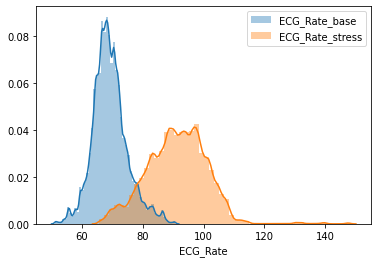

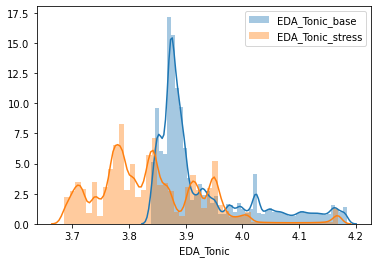

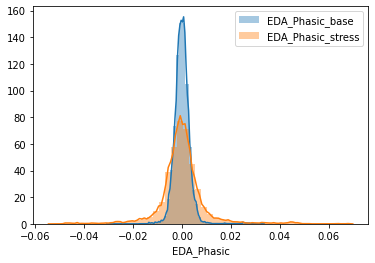


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-1327.8678036454558, pvalue=0.0)
Pearsonr result (r,p): (-0.020886670253385965, 2.0229373071477808e-46)
EDA_Tonic
Ttest_indResult(statistic=487.59336280351306, pvalue=0.0)
Pearsonr result (r,p): (-0.7298203855170254, 0.0)
EDA_Phasic
Ttest_indResult(statistic=0.786478636813038, pvalue=0.4315873286000972)
Pearsonr result (r,p): (0.024432464412368515, 7.325185595003576e-63)


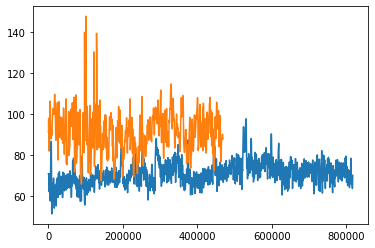

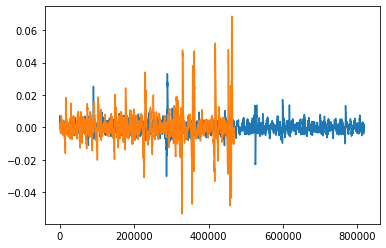

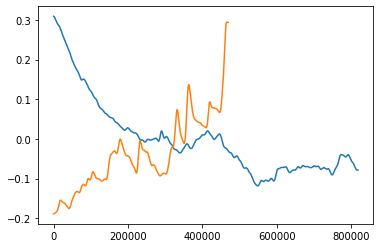


------------------------------------------

Analysis of subject S9 

{'ACC': 3656100, 'ECG': 3656100, 'EMG': 3656100, 'EDA': 3656100, 'Temp': 3656100, 'Resp': 3656100}
bio_process...
826000
451500

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.10847083]
 [-0.10847083  1.        ]]
EDA_Tonic: 
[[ 1.         -0.96356877]
 [-0.96356877  1.        ]]
EDA_Phasic: 
[[ 1.        -0.0096119]
 [-0.0096119  1.       ]]


Mean of Heart-Rate
76.64900353354933
79.91349907685435

Mean of EDA_Tonic
1.7490468274867401
3.3632881199446767

Mean of EDA_Phasic
1.1621531704580176e-05
4.2716018229100276e-06

Standart Deviation
ECG_Rate-> base: 5.984408346992222, stress: 8.72657140580285
EDA_Tonic-> base: 0.14439919113721536, stress: 0.332449669622478
EDA_Phasic-> base: 0.0038131754835404605, stress: 0.020675416147814832


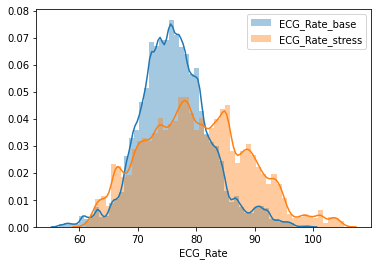

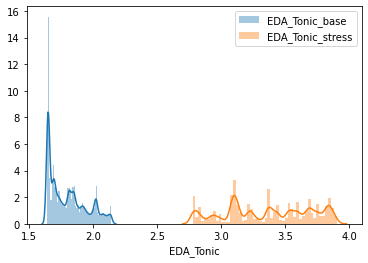

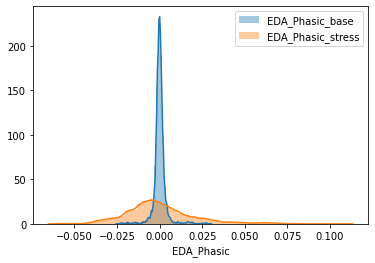


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-231.1683086635128, pvalue=0.0)
Pearsonr result (r,p): (-0.1084708250594915, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-2903.73637986028, pvalue=0.0)
Pearsonr result (r,p): (-0.9635687722425156, 0.0)
EDA_Phasic
Ttest_indResult(statistic=1.707191852441488, pvalue=0.08778674268517306)
Pearsonr result (r,p): (-0.00961190003111928, 1.0558714634043273e-10)


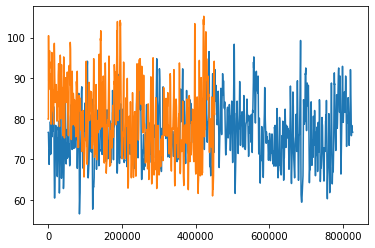

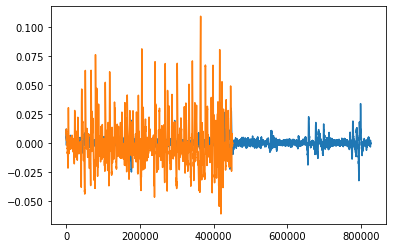

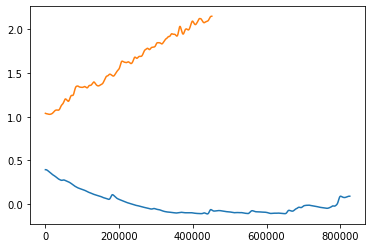


------------------------------------------

Analysis of subject S10 

{'ACC': 3847200, 'ECG': 3847200, 'EMG': 3847200, 'EDA': 3847200, 'Temp': 3847200, 'Resp': 3847200}
bio_process...
826000
507500

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.27171588]
 [-0.27171588  1.        ]]
EDA_Tonic: 
[[1.        0.0223894]
 [0.0223894 1.       ]]
EDA_Phasic: 
[[1.00000000e+00 5.45251282e-04]
 [5.45251282e-04 1.00000000e+00]]


Mean of Heart-Rate
98.73706423530828
107.40635821128171

Mean of EDA_Tonic
0.7875083415170726
1.8428705223790653

Mean of EDA_Phasic
2.985704910030807e-06
-4.5378731601240664e-07

Standart Deviation
ECG_Rate-> base: 7.206687472200564, stress: 13.183735634152129
EDA_Tonic-> base: 0.01654787540285524, stress: 0.17937848418697813
EDA_Phasic-> base: 0.0015275202967187562, stress: 0.009537082639662265


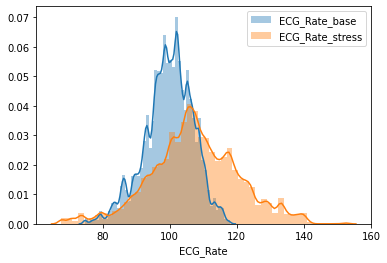

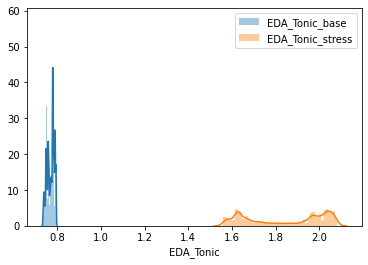

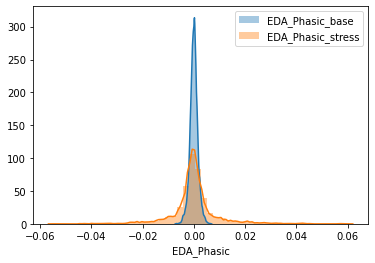


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-367.34224694114795, pvalue=0.0)
Pearsonr result (r,p): (-0.27171587997239094, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-4245.722177688683, pvalue=0.0)
Pearsonr result (r,p): (0.022389397330005556, 2.761358073494535e-57)
EDA_Phasic
Ttest_indResult(statistic=0.44576799187271815, pvalue=0.6557649400995109)
Pearsonr result (r,p): (0.0005452512823495748, 0.6976972396688591)


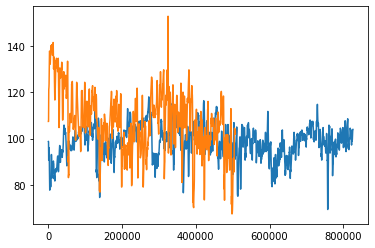

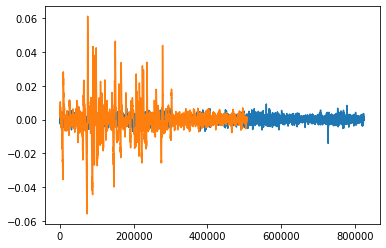

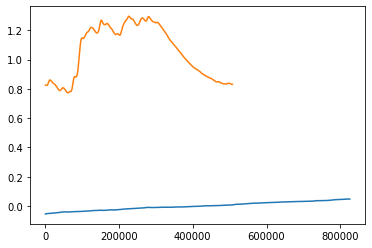


------------------------------------------

Analysis of subject S11 

{'ACC': 3663100, 'ECG': 3663100, 'EMG': 3663100, 'EDA': 3663100, 'Temp': 3663100, 'Resp': 3663100}
bio_process...
826000
476000

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.14461976]
 [-0.14461976  1.        ]]
EDA_Tonic: 
[[ 1.         -0.68883201]
 [-0.68883201  1.        ]]
EDA_Phasic: 
[[ 1.         -0.01258016]
 [-0.01258016  1.        ]]


Mean of Heart-Rate
74.14658435187837
124.66209581458479

Mean of EDA_Tonic
6.088021303035151
6.962119422765406

Mean of EDA_Phasic
1.1371177316040342e-05
3.686132093682638e-05

Standart Deviation
ECG_Rate-> base: 5.669038690626839, stress: 7.237486333290395
EDA_Tonic-> base: 0.17366779753568934, stress: 0.329396320869934
EDA_Phasic-> base: 0.004390984564993112, stress: 0.016894501213495314


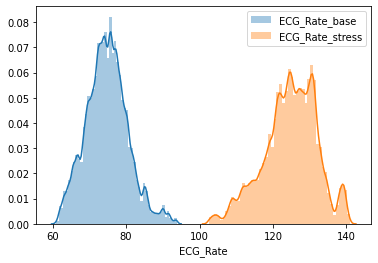

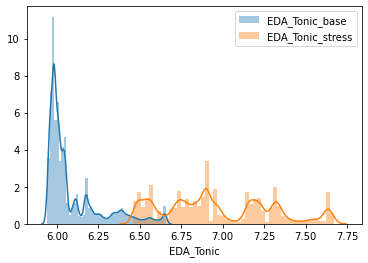

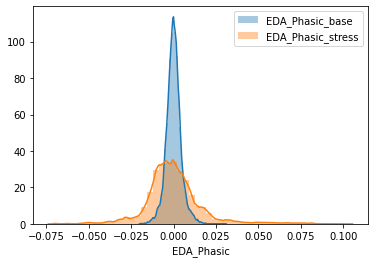


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-3742.3503132773876, pvalue=0.0)
Pearsonr result (r,p): (-0.14461976117149153, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-1606.837271360693, pvalue=0.0)
Pearsonr result (r,p): (-0.6888320082668358, 0.0)
EDA_Phasic
Ttest_indResult(statistic=-0.5260809634229913, pvalue=0.5988320772276361)
Pearsonr result (r,p): (-0.01258016344000975, 3.967382027949031e-18)


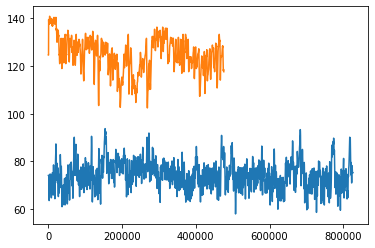

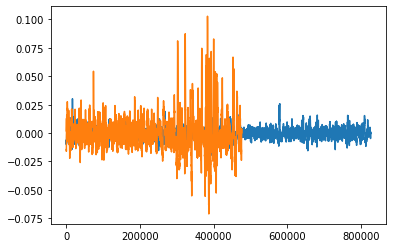

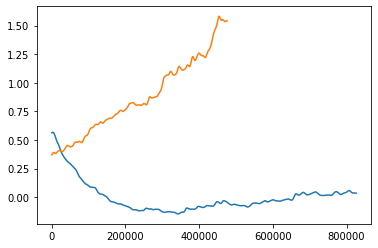


------------------------------------------

Analysis of subject S13 

{'ACC': 3875900, 'ECG': 3875900, 'EMG': 3875900, 'EDA': 3875900, 'Temp': 3875900, 'Resp': 3875900}
bio_process...
826001
464800

Covariance Matrix

ECG_Rate: 
[[1.         0.11994618]
 [0.11994618 1.        ]]
EDA_Tonic: 
[[1.         0.11001898]
 [0.11001898 1.        ]]
EDA_Phasic: 
[[ 1.         -0.03095444]
 [-0.03095444  1.        ]]


Mean of Heart-Rate
87.00742217489211
108.42459644753455

Mean of EDA_Tonic
2.3517104649482024
4.59779447712698

Mean of EDA_Phasic
-4.632315070187818e-06
9.982187213062134e-06

Standart Deviation
ECG_Rate-> base: 6.564618070208953, stress: 12.075374215737325
EDA_Tonic-> base: 0.01597731183122812, stress: 0.7926249905807854
EDA_Phasic-> base: 0.0037821721264759385, stress: 0.04655623487486756


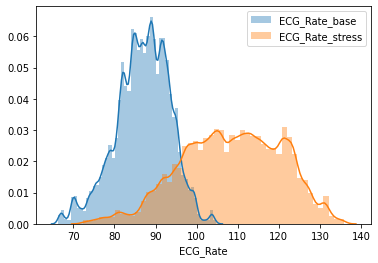

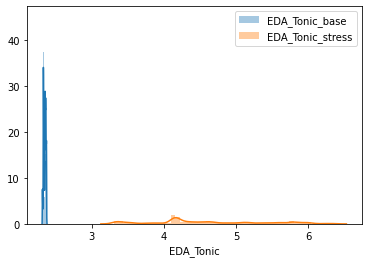

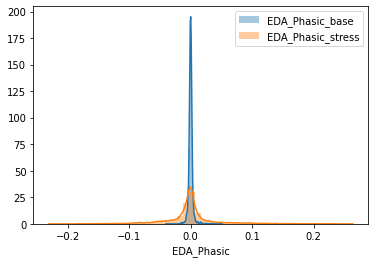


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-1069.361714288335, pvalue=0.0)
Pearsonr result (r,p): (0.11994617533222088, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-1933.0486431389056, pvalue=0.0)
Pearsonr result (r,p): (0.11001898257435158, 0.0)
EDA_Phasic
Ttest_indResult(statistic=-0.2952640124598794, pvalue=0.7677922714559872)
Pearsonr result (r,p): (-0.030954442931624592, 6.634002216063658e-99)


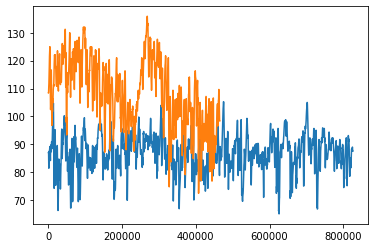

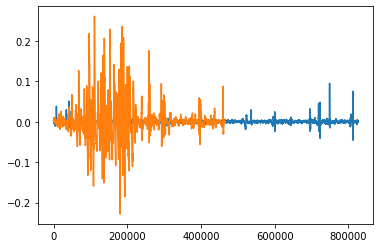

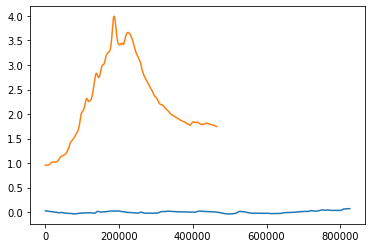


------------------------------------------

Analysis of subject S14 

{'ACC': 3883600, 'ECG': 3883600, 'EMG': 3883600, 'EDA': 3883600, 'Temp': 3883600, 'Resp': 3883600}
bio_process...
826000
472500

Covariance Matrix

ECG_Rate: 
[[ 1.         -0.00893872]
 [-0.00893872  1.        ]]
EDA_Tonic: 
[[ 1.         -0.20470164]
 [-0.20470164  1.        ]]
EDA_Phasic: 
[[ 1.         -0.00831401]
 [-0.00831401  1.        ]]


Mean of Heart-Rate
73.22243143706923
126.6620418964121

Mean of EDA_Tonic
2.8078625184318766
2.9649959310137426

Mean of EDA_Phasic
3.7924751903839855e-05
-1.4976688171244528e-05

Standart Deviation
ECG_Rate-> base: 4.699450695782641, stress: 12.096282196269177
EDA_Tonic-> base: 0.012060274724064447, stress: 0.029037275152668456
EDA_Phasic-> base: 0.0034197567360188213, stress: 0.007903226087462948


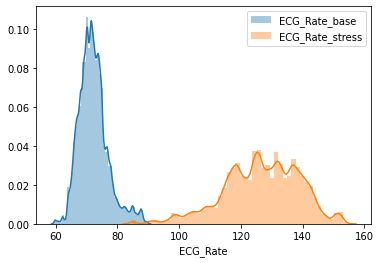

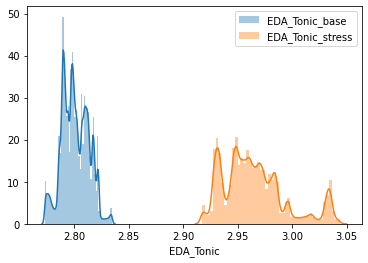

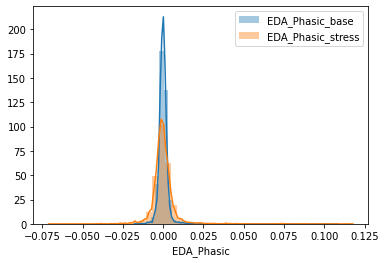


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-2885.1418287281613, pvalue=0.0)
Pearsonr result (r,p): (-0.008938719278212902, 8.023593460332139e-10)
EDA_Tonic
Ttest_indResult(statistic=-3586.9133926770046, pvalue=0.0)
Pearsonr result (r,p): (-0.20470164161453153, 0.0)
EDA_Phasic
Ttest_indResult(statistic=6.72618442546419, pvalue=1.7426825227437314e-11)
Pearsonr result (r,p): (-0.008314012708018723, 1.0968949232593516e-08)


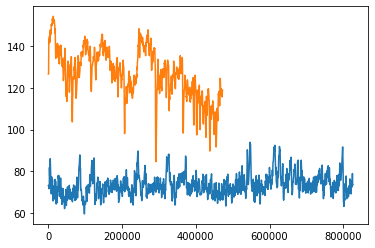

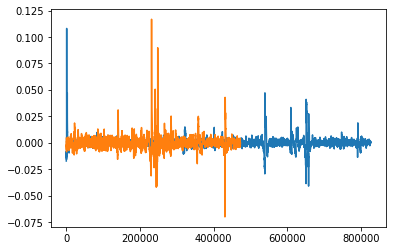

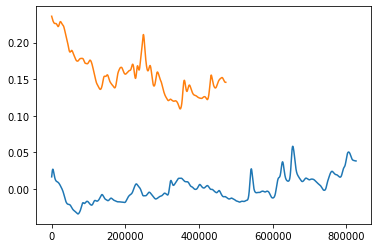


------------------------------------------

Analysis of subject S15 

{'ACC': 3676400, 'ECG': 3676400, 'EMG': 3676400, 'EDA': 3676400, 'Temp': 3676400, 'Resp': 3676400}
bio_process...
822500
480200

Covariance Matrix

ECG_Rate: 
[[1.         0.00556097]
 [0.00556097 1.        ]]
EDA_Tonic: 
[[1.         0.98047187]
 [0.98047187 1.        ]]
EDA_Phasic: 
[[1.        0.0120804]
 [0.0120804 1.       ]]


Mean of Heart-Rate
82.74197151736726
84.7730886378078

Mean of EDA_Tonic
1.795644228356307
3.4279414242054114

Mean of EDA_Phasic
2.554681548678462e-05
-3.4215584441791932e-06

Standart Deviation
ECG_Rate-> base: 6.518259472373277, stress: 7.624644574107977
EDA_Tonic-> base: 0.12776572600914132, stress: 0.0852205090702347
EDA_Phasic-> base: 0.004034941229834427, stress: 0.011332456640334262


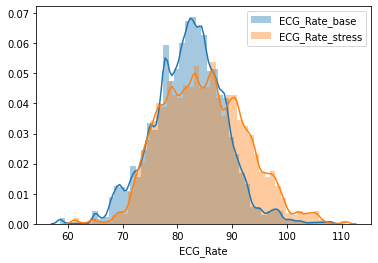

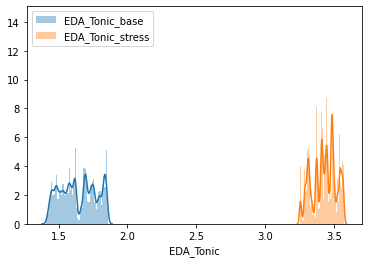

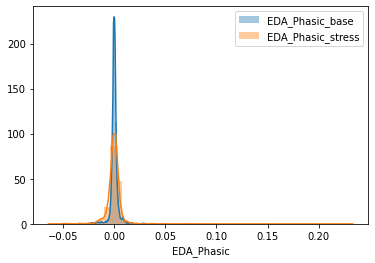


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-181.90975204301932, pvalue=0.0)
Pearsonr result (r,p): (0.0055609746440275845, 0.00011640387878701876)
EDA_Tonic
Ttest_indResult(statistic=-8055.636352629585, pvalue=0.0)
Pearsonr result (r,p): (0.9804718744571359, 0.0)
EDA_Phasic
Ttest_indResult(statistic=2.888145332839239, pvalue=0.003875294289195381)
Pearsonr result (r,p): (0.012080403464763958, 5.685261078785015e-17)


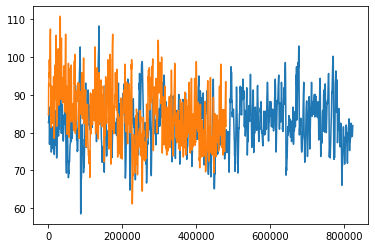

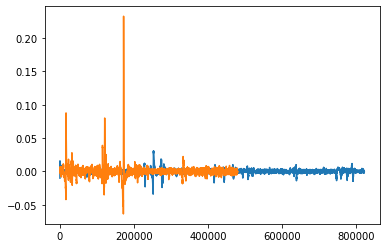

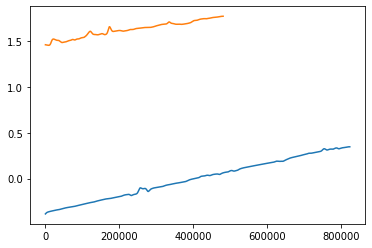


------------------------------------------

Analysis of subject S16 

{'ACC': 3941700, 'ECG': 3941700, 'EMG': 3941700, 'EDA': 3941700, 'Temp': 3941700, 'Resp': 3941700}
bio_process...
826000
471101

Covariance Matrix

ECG_Rate: 
[[1.         0.19217229]
 [0.19217229 1.        ]]
EDA_Tonic: 
[[1.         0.66651491]
 [0.66651491 1.        ]]
EDA_Phasic: 
[[ 1.        -0.0079099]
 [-0.0079099  1.       ]]


Mean of Heart-Rate
65.28411765456877
128.07683027171657

Mean of EDA_Tonic
0.9711693910903492
3.934794383530878

Mean of EDA_Phasic
-1.593746738018566e-05
-6.877243780184698e-05

Standart Deviation
ECG_Rate-> base: 6.680017750676069, stress: 11.723073622054045
EDA_Tonic-> base: 0.011619712974400115, stress: 0.7726721773827405
EDA_Phasic-> base: 0.001730963998380936, stress: 0.0397271776143062


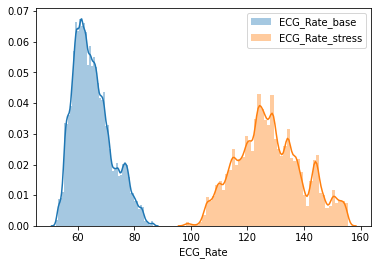

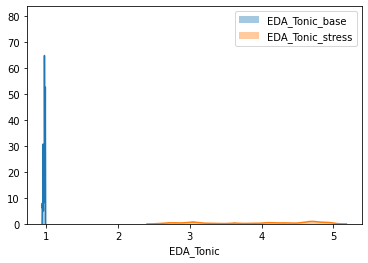

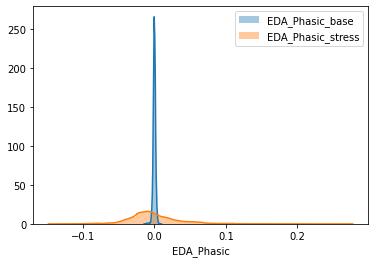


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-3198.141207214784, pvalue=0.0)
Pearsonr result (r,p): (0.19217228952263066, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-2631.8103418758114, pvalue=0.0)
Pearsonr result (r,p): (0.6665149106143247, 0.0)
EDA_Phasic
Ttest_indResult(statistic=0.7111784177720415, pvalue=0.47697385692381544)
Pearsonr result (r,p): (-0.007909899635999765, 5.6615996258259314e-08)


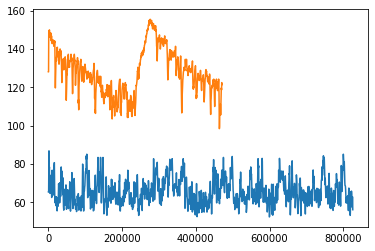

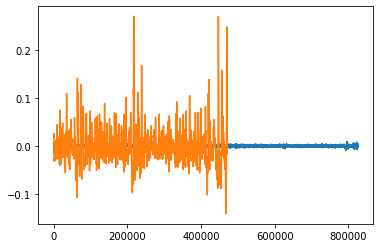

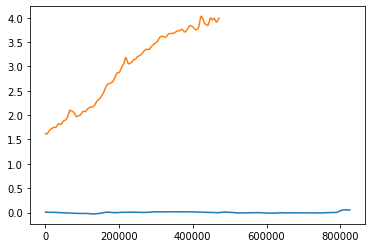


------------------------------------------

Analysis of subject S17 

{'ACC': 4144000, 'ECG': 4144000, 'EMG': 4144000, 'EDA': 4144000, 'Temp': 4144000, 'Resp': 4144000}
bio_process...
826700
506100

Covariance Matrix

ECG_Rate: 
[[1.         0.07930025]
 [0.07930025 1.        ]]
EDA_Tonic: 
[[ 1.        -0.1124389]
 [-0.1124389  1.       ]]
EDA_Phasic: 
[[ 1.         -0.09251167]
 [-0.09251167  1.        ]]


Mean of Heart-Rate
66.52717439143476
113.56461776048945

Mean of EDA_Tonic
5.424999056480266
7.283398878405286

Mean of EDA_Phasic
-1.0389698112912566e-05
-1.069952819262706e-05

Standart Deviation
ECG_Rate-> base: 7.938567422047889, stress: 16.069810565916157
EDA_Tonic-> base: 0.06361548465221607, stress: 0.11264204653517496
EDA_Phasic-> base: 0.004502279034011182, stress: 0.012172589073284097


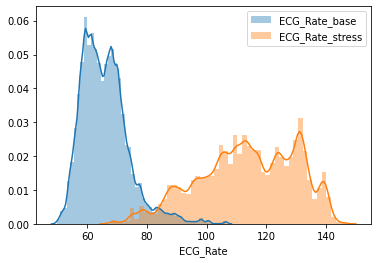

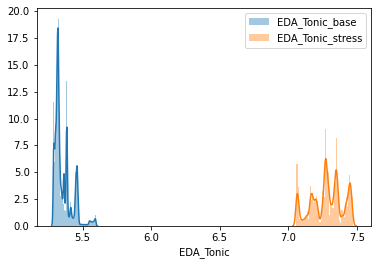

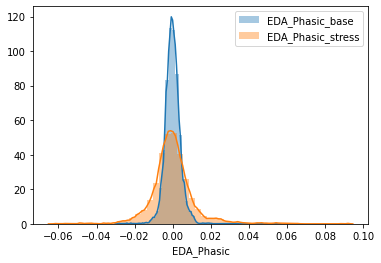


Correlation tests
ECG_Rate
Ttest_indResult(statistic=-1892.5181658957283, pvalue=0.0)
Pearsonr result (r,p): (0.07930024827607787, 0.0)
EDA_Tonic
Ttest_indResult(statistic=-10594.139552038485, pvalue=0.0)
Pearsonr result (r,p): (-0.11243889739412972, 0.0)
EDA_Phasic
Ttest_indResult(statistic=0.17426431446898, pvalue=0.8616577778742682)
Pearsonr result (r,p): (-0.09251166927618076, 0.0)


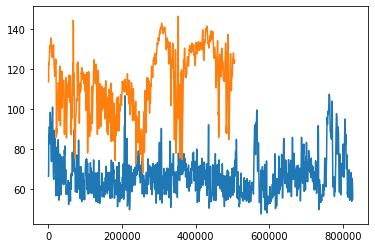

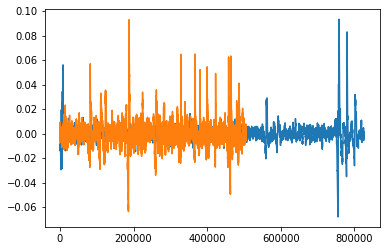

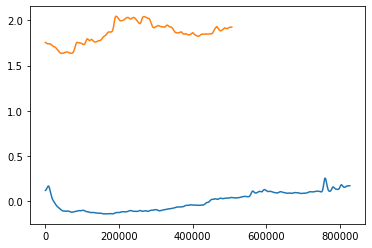

In [47]:
subject_names = ['S2','S3', 'S4','S5','S6','S7', 'S8','S9','S10','S11', 'S13','S14','S15','S16', 'S17']

for sbj_name in subject_names:
    print("\n------------------------------------------\n")
    print("Analysis of subject {} \n".format(sbj_name))
    get = read_data_of_one_subject(sbj_name)
    chest_data_dict = get.get_chest_data()
    chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}
    print(chest_dict_length)
    #print(wrist_dict_length)
    #get labels
    labels = get.get_labels()
    baseline = np.asarray([idx for idx,val in enumerate(labels) if val == subject_state.BASELINE])
    stressful = np.asarray([idx for idx,val in enumerate(labels) if val == subject_state.STRESSFUL])
    print("bio_process...")
    bio_df_base, bio_info_base = nk.bio_process(ecg=chest_data_dict["ECG"][baseline].flatten(), 
                                  eda=chest_data_dict["EDA"][baseline].flatten(), sampling_rate=700)
    bio_df_stress, bio_info_stress = nk.bio_process(ecg=chest_data_dict["ECG"][stressful].flatten(), 
                                  eda=chest_data_dict["EDA"][stressful].flatten(), sampling_rate=700)
    
    lb = len(bio_df_base["ECG_Rate"])
    ls = len(bio_df_stress["ECG_Rate"])
    print(len(bio_df_base["ECG_Rate"])) # heart - rate
    print(len(bio_df_stress["ECG_Rate"]))
    
    print("\nCovariance Matrix\n")
    print("ECG_Rate: \n{}".format(np.corrcoef(bio_df_base["ECG_Rate"][:ls], bio_df_stress["ECG_Rate"][:ls])))
    print("EDA_Tonic: \n{}".format(np.corrcoef(bio_df_base["EDA_Tonic"][:ls], bio_df_stress["EDA_Tonic"][:ls])))
    print("EDA_Phasic: \n{}".format(np.corrcoef(bio_df_base["EDA_Phasic"][:ls], bio_df_stress["EDA_Phasic"][:ls])))
    print("\n")
    print("Mean of Heart-Rate") 
    print(np.mean(bio_df_base["ECG_Rate"]))
    print(np.mean(bio_df_stress["ECG_Rate"]))
    print("\nMean of EDA_Tonic")
    print(np.mean(bio_df_base["EDA_Tonic"]))
    print(np.mean(bio_df_stress["EDA_Tonic"]))
    print("\nMean of EDA_Phasic")
    print(np.mean(bio_df_base["EDA_Phasic"]))
    print(np.mean(bio_df_stress["EDA_Phasic"]))
    print("\nStandart Deviation")
    print("ECG_Rate-> base: {}, stress: {}".format(bio_df_base["ECG_Rate"][:ls].std(),bio_df_stress["ECG_Rate"][:ls].std() ))
    print("EDA_Tonic-> base: {}, stress: {}".format(bio_df_base["EDA_Tonic"][:ls].std(),bio_df_stress["EDA_Tonic"][:ls].std() ))
    print("EDA_Phasic-> base: {}, stress: {}".format(bio_df_base["EDA_Phasic"][:ls].std(),bio_df_stress["EDA_Phasic"][:ls].std() ))

    #distribution graph
    sns.distplot(bio_df_base["ECG_Rate"][:ls], label='ECG_Rate_base')
    sns.distplot(bio_df_stress["ECG_Rate"][:ls], label='ECG_Rate_stress')
    plt.legend()
    plt.show()

    sns.distplot(bio_df_base["EDA_Tonic"][:ls], label='EDA_Tonic_base')
    sns.distplot(bio_df_stress["EDA_Tonic"][:ls], label='EDA_Tonic_stress')
    plt.legend()
    plt.show()

    sns.distplot(bio_df_base["EDA_Phasic"][:ls], label='EDA_Phasic_base')
    sns.distplot(bio_df_stress["EDA_Phasic"][:ls], label='EDA_Phasic_stress')
    plt.legend()
    plt.show()

    #Correlation
    print("\nCorrelation tests")
    print("ECG_Rate")
    print(ttest_ind(bio_df_base["ECG_Rate"][:ls], bio_df_stress["ECG_Rate"][:ls]))
    print("Pearsonr result (r,p): {}".format(pearsonr(bio_df_base["ECG_Rate"][:ls], bio_df_stress["ECG_Rate"][:ls])))
    print("EDA_Tonic")
    print(ttest_ind(bio_df_base["EDA_Tonic"][:ls], bio_df_stress["EDA_Tonic"][:ls]))
    print("Pearsonr result (r,p): {}".format(pearsonr(bio_df_base["EDA_Tonic"][:ls], bio_df_stress["EDA_Tonic"][:ls])))
    print("EDA_Phasic")
    print(ttest_ind(bio_df_base["EDA_Phasic"][:ls], bio_df_stress["EDA_Phasic"][:ls]))
    print("Pearsonr result (r,p): {}".format(pearsonr(bio_df_base["EDA_Phasic"][:ls], bio_df_stress["EDA_Phasic"][:ls])))

    plt.plot(bio_df_base["ECG_Rate"])
    plt.plot(bio_df_stress["ECG_Rate"])
    plt.show()

    plt.plot(bio_df_base["EDA_Phasic"])
    plt.plot(bio_df_stress["EDA_Phasic"])
    plt.show()
    mean_eda_tonic = np.mean(bio_df_base["EDA_Tonic"])
    plt.plot(bio_df_base["EDA_Tonic"] - mean_eda_tonic)
    plt.plot(bio_df_stress["EDA_Tonic"] - mean_eda_tonic)
    plt.show()
    

## Arrange the dataset that will be trained

In [6]:
#merge all the processed signal (eda-phasic, tonic, hr, hrv)

if(bio_df_base["ECG_Rate"].shape == bio_df_base["EDA_Tonic"].shape  == bio_df_base["EDA_Phasic"].shape ):
    print("Processed baseline values are equal...")
    
if(bio_df_stress["ECG_Rate"].shape == bio_df_stress["EDA_Tonic"].shape  == bio_df_stress["EDA_Phasic"].shape ):
    print("Processed stressful values are equal...")


#for the tonic implementation, we need to substact the mean of the baseline from the overall to adjust it    
last_heart_rate = np.concatenate((bio_df_base["ECG_Rate"], bio_df_stress["ECG_Rate"]))
last_eda_tonic  = np.concatenate((bio_df_base["EDA_Tonic"]-mean_eda_tonic, bio_df_stress["EDA_Tonic"]-mean_eda_tonic))
last_eda_phasic = np.concatenate((bio_df_base["EDA_Phasic"], bio_df_stress["EDA_Phasic"]))
last_labels     = np.concatenate((labels[baseline], labels[stressful])) #merge baseline and stresfull labels 

if(last_heart_rate.shape == last_eda_tonic.shape == last_eda_phasic.shape == last_labels.shape):
    print("Succesfully merged!")
else:
    print("Merge Error!")
    
processed_train = np.array([last_heart_rate, last_eda_tonic, last_eda_phasic])
processed_test  = np.array([last_labels])
                            
merged_np_array = np.array([last_heart_rate, last_eda_tonic, last_eda_phasic, last_labels])
merged_np_array = merged_np_array.T
df_processed = pd.DataFrame(data=merged_np_array, columns=["ECG_Rate_data", "EDA_Tonic_data", "EDA_Phasic", "label_data"]) 

is_normalize = False
do_IQR_process = False
if do_IQR_process:
    print(df_processed.shape)
    print(df_processed.info)
    display(df_processed.describe)

    Q1_p = df_processed.quantile(0.25)
    Q3_p = df_processed.quantile(0.75)
    IQR_p = Q3_p - Q1_p
    print("IQR is\n", IQR_p)

    print()
    df_out_p = df_processed[~((df_processed < (Q1_p - 1.5 * IQR_p)) |(df_processed > (Q3_p + 1.5 * IQR_p))).any(axis=1)]
    print(df_out_p.shape)


    #mean normalization 
    norm_df_out_p=(df_out_p-df_out_p.mean())/df_out_p.std()
    #min-max normalization:
    #norm_df_out=(df_out-df_out.min())/(df_out.max()-df_out.min())

    norm_y = df_out_p.label_data #keep original labels Dont normalize labels
    norm_x = norm_df_out_p.drop('label_data',axis=1)


    norm_x_train,norm_x_test,norm_y_train,norm_y_test=train_test_split(norm_x,norm_y,test_size=0.2)
    display(norm_df_out_p.head())
    display(norm_df_out_p.describe())
    display(norm_df_out_p.info())
    display(norm_df_out_p.shape)
    
    plt.figure(figsize=(12,10))
    cor = norm_x.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
else:
    print("---------------------------------------")
    print("without IQR")
    
    if is_normalize:
        norm_df_out_p=(df_processed-df_processed.mean())/df_processed.std()
        norm_x = norm_df_out_p.drop('label_data',axis=1) #input data 
        norm_y = df_processed.label_data #output data
    else:
        norm_x = df_processed.drop('label_data',axis=1) #input data
        norm_y = df_processed.label_data #output data
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(norm_x,norm_y,test_size=0.2)
    display(x_train_p)
    display(y_train_p)

Processed baseline values are equal...
Processed stressful values are equal...
Succesfully merged!
---------------------------------------
without IQR


,ECG_Rate_data,EDA_Tonic_data,EDA_Phasic
1057865,91.864070,4.997613,-0.024854
482601,63.254631,-0.358982,0.000998
167677,60.206373,0.337299,0.001997
1217575,83.070045,5.655886,0.065777
883347,101.638224,5.844615,-0.121848
...,...,...,...
705618,59.988866,-0.365680,0.002708
476140,63.372144,-0.353305,-0.000133
702427,61.993321,-0.364493,-0.002134
704129,64.497635,-0.364682,0.005664


1057865    2.0
482601     1.0
167677     1.0
1217575    2.0
883347     2.0
          ... 
705618     1.0
476140     1.0
702427     1.0
704129     1.0
305776     1.0
Name: label_data, Length: 1032080, dtype: float64

# Modals Training Section

### LDA 

In [ ]:
LDA= LinearDiscriminantAnalysis(solver = 'svd')
y_out = LDA.fit(x_train_p, y_train_p)
LDA_pred = y_out.predict(x_test_p)
print(classification_report(y_test_p, LDA_pred, digits=2))

In [371]:
#Knn training and accuracy
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train_p, y_train_p)
y_pred = knn.predict(x_test_p)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_p, y_pred))


Accuracy: 1.0


### KNN

In [365]:
# Knn training cross validation results
#Do base mdel with test and train data, show improvement in next section with cross validation
knn = KNeighborsClassifier(n_neighbors=5)
norm_y_out = cross_val_predict(knn, x_train_p, y_train_p, cv=10) #10-cross validation
print(classification_report(y_train_p, norm_y_out, digits=4))


              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000    671248
         2.0     1.0000    1.0000    1.0000    360832

    accuracy                         1.0000   1032080
   macro avg     1.0000    1.0000    1.0000   1032080
weighted avg     1.0000    1.0000    1.0000   1032080



In [347]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10)

clf_i = clf.fit(x_train_p,y_train_p)

y_out_i = clf_i.predict(x_test_p)

lm_i=(classification_report(y_test_p, y_out_i, digits=4))
print(lm_i)

inp = np.array([111,6.555572,0.154950])
y = clf_i.predict(inp.reshape(1,-1))
print("Accuracy:",metrics.accuracy_score([2], y))

              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000    167352
         2.0     1.0000    1.0000    1.0000     90668

    accuracy                         1.0000    258020
   macro avg     1.0000    1.0000    1.0000    258020
weighted avg     1.0000    1.0000    1.0000    258020

Accuracy: 0.0


### Decision Tree

In [300]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)


norm_y_out = cross_val_predict(clf, x_train_p, y_train_p, cv=10)

lm=(classification_report(y_train_p, norm_y_out, digits=4))
print(lm)

              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000    671142
         2.0     1.0000    1.0000    1.0000    360938

    accuracy                         1.0000   1032080
   macro avg     1.0000    1.0000    1.0000   1032080
weighted avg     1.0000    1.0000    1.0000   1032080



### SVM

In [388]:
#svm = SVC(kernel='rbf', random_state=0, gamma=10, C=1)
#1000 iterations take 25 minutes
from sklearn import svm

#Create a svm Classifier
svm_model = svm.SVC(kernel='rbf', random_state=0, gamma=10, C=100,
              shrinking=True, tol=1.000, cache_size=10) ##(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_model.fit(x_train_p, y_train_p)

#Predict the response for test dataset
y_out = svm_model.predict(x_test_p)
lm_svc=(classification_report(y_test_p, y_out, digits=4))
print(lm_svc)



              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000    167879
         2.0     1.0000    1.0000    1.0000     90141

    accuracy                         1.0000    258020
   macro avg     1.0000    1.0000    1.0000    258020
weighted avg     1.0000    1.0000    1.0000    258020



In [398]:
inp = np.array([80,1.555572,0.154950])
y = svm_model.predict(inp.reshape(1,-1))
print("Accuracy:",metrics.accuracy_score([2], y))

Accuracy: 1.0


## Save and Load Modals

In [372]:
#save the obtained modal
with open('clf.pickle', 'wb') as f:
    pickle.dump(knn, f)

In [59]:
#load the saved model again
with open('clf.pickle', 'rb') as f:
    clf = pickle.load(f)

#test the modal with random values
inp = np.array([76,2.85572,0.2950])
y = clf.predict(inp.reshape(1,-1))
print("Accuracy:",metrics.accuracy_score([2], y))

Accuracy: 0.0


## Other Analysis on Dataset

In [301]:
# Merge the dataset that has not been processed

base_ecg_data_1 = chest_data_dict["ECG"][:,0][baseline]
strs_ecg_data_1 = chest_data_dict["ECG"][:,0][stressful]

base_eda_data_1 = chest_data_dict["EDA"][:,0][baseline]
strs_eda_data_1 = chest_data_dict["EDA"][:,0][stressful]

last_ecg_data = np.concatenate((base_ecg_data_1, strs_ecg_data_1))    #merge baseline and stressful dataset
last_eda_data = np.concatenate((base_eda_data_1, strs_eda_data_1))    #merge baseline and stressful dataset
last_labels   = np.concatenate((labels[baseline], labels[stressful])) #merge baseline and stresfull labels 

if(last_ecg_data.shape == last_eda_data.shape == last_labels.shape):
    print("Succesfully merged!")
else:
    print("Merge Error!")
    
print(last_ecg_data.shape)
print(last_eda_data.shape)
print(last_labels.shape)


Succesfully merged!
(1290100,)
(1290100,)
(1290100,)


In [302]:
# Combine the processed dataset data that will be used for the model training process

numpy_data1 = np.array([last_ecg_data, last_eda_data, last_labels])
numpy_data1 = numpy_data1.T

df = pd.DataFrame(data=numpy_data1, columns=["ecg_data", "eda_data", "label_data"]) 

print(df.shape)
print(df.info)
display(df.describe)

(1290100, 3)
<bound method DataFrame.info of          ecg_data  eda_data  label_data
0       -0.028976  6.387711         1.0
1       -0.029114  6.384277         1.0
2       -0.030212  6.398392         1.0
3       -0.030991  6.392288         1.0
4       -0.031906  6.385803         1.0
...           ...       ...         ...
1290095  0.158249  9.645081         2.0
1290096  0.137375  9.645081         2.0
1290097  0.113342  9.645844         2.0
1290098  0.088486  9.645844         2.0
1290099  0.069534  9.647751         2.0

[1290100 rows x 3 columns]>


<bound method NDFrame.describe of          ecg_data  eda_data  label_data
0       -0.028976  6.387711         1.0
1       -0.029114  6.384277         1.0
2       -0.030212  6.398392         1.0
3       -0.030991  6.392288         1.0
4       -0.031906  6.385803         1.0
...           ...       ...         ...
1290095  0.158249  9.645081         2.0
1290096  0.137375  9.645081         2.0
1290097  0.113342  9.645844         2.0
1290098  0.088486  9.645844         2.0
1290099  0.069534  9.647751         2.0

[1290100 rows x 3 columns]>

In [303]:
# Combine the raw dataset that will be used for the model training process

numpy_data1 = np.array([chest_data_dict["ECG"][:,0], chest_data_dict["EDA"][:,0], labels])
numpy_data1 = numpy_data1.T

df = pd.DataFrame(data=numpy_data1, columns=["ecg_data", "eda_data", "label_data"]) 

print(df.shape)
print(df.info)
display(df.describe)


(4380600, 3)
<bound method DataFrame.info of          ecg_data   eda_data  label_data
0       -0.275803   3.888321         0.0
1       -0.229752   3.913116         0.0
2       -0.195282   3.873062         0.0
3       -0.164474   3.883362         0.0
4       -0.134811   3.886795         0.0
...           ...        ...         ...
4380595 -0.008240  10.231400         0.0
4380596 -0.000778  10.231018         0.0
4380597  0.014877  10.231018         0.0
4380598  0.029251  10.230637         0.0
4380599  0.038864  10.230637         0.0

[4380600 rows x 3 columns]>


<bound method NDFrame.describe of          ecg_data   eda_data  label_data
0       -0.275803   3.888321         0.0
1       -0.229752   3.913116         0.0
2       -0.195282   3.873062         0.0
3       -0.164474   3.883362         0.0
4       -0.134811   3.886795         0.0
...           ...        ...         ...
4380595 -0.008240  10.231400         0.0
4380596 -0.000778  10.231018         0.0
4380597  0.014877  10.231018         0.0
4380598  0.029251  10.230637         0.0
4380599  0.038864  10.230637         0.0

[4380600 rows x 3 columns]>

In [304]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print("IQR is\n", IQR)

print()
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_out.shape)


IQR is
 ecg_data      0.082535
eda_data      3.987122
label_data    2.000000
dtype: float64

(3837645, 3)


In [305]:
#for the raw dataset - run this code

df_out_baseline = np.asarray([idx for idx,val in enumerate(df_out["label_data"].to_numpy()) if val == subject_state.BASELINE])
df_out_stress = np.asarray([idx for idx,val in enumerate(df_out["label_data"].to_numpy()) if val == subject_state.STRESSFUL])

bio_df_out_base, bio_out_info_base = nk.bio_process(ecg=df_out["ecg_data"].to_numpy()[df_out_baseline].flatten(), 
                                            eda=df_out["eda_data"].to_numpy()[df_out_baseline].flatten(), sampling_rate=700)

bio_df_out_stress, bio_out_info_stress = nk.bio_process(ecg=df_out["ecg_data"].to_numpy()[df_out_stress].flatten(), 
                                            eda=df_out["eda_data"].to_numpy()[df_out_stress].flatten(), sampling_rate=700)



777731
377109


array([361.42857143, 442.85714286, 525.71428571, 434.28571429,
       352.85714286, 432.85714286, 510.        , 411.42857143,
       372.85714286, 431.42857143, 490.        , 420.        ,
       378.57142857, 380.        , 401.42857143, 402.85714286,
       348.57142857, 410.        , 410.        , 475.71428571,
       544.28571429, 485.71428571, 485.71428571, 540.        ,
       304.28571429, 304.28571429, 245.71428571, 304.28571429,
       305.71428571, 471.42857143])

array([508.57142857, 545.71428571, 541.42857143, 535.71428571,
       528.57142857, 541.42857143, 550.        , 551.42857143,
       540.        , 512.85714286, 512.85714286, 520.        ,
       505.71428571, 505.71428571, 500.        , 488.57142857,
       510.        , 538.57142857, 558.57142857, 570.        ,
       577.14285714, 567.14285714, 560.        , 514.28571429,
       512.85714286, 478.57142857, 484.28571429, 441.42857143,
       452.85714286, 474.28571429])

[[1.         0.09511716]
 [0.09511716 1.        ]]
310.6248506571087
398.28616684266103
[[1.         0.03895963]
 [0.03895963 1.        ]]
[[1.         0.07903171]
 [0.07903171 1.        ]]
[[ 1.         -0.02613066]
 [-0.02613066  1.        ]]
136.97388838940594
105.76622996487605


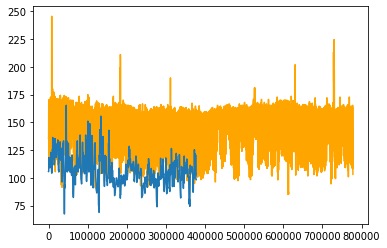

In [306]:
#ECG - heart rate analysis
lb = len(bio_df_out_base["ECG_Rate"])
ls = len(bio_df_out_stress["ECG_Rate"])

print(len(bio_df_out_base["ECG_Rate"]))
print(len(bio_df_out_stress["ECG_Rate"]))

hrv_out_base   = bio_out_info_base["ECG_R_Peaks"][1:] - bio_out_info_base["ECG_R_Peaks"][0:len(bio_out_info_base["ECG_R_Peaks"])-1]
hrv_out_stress = bio_out_info_stress["ECG_R_Peaks"][1:] - bio_out_info_stress["ECG_R_Peaks"][0:len(bio_out_info_stress["ECG_R_Peaks"])-1] 
hrv_out_base += 1
hrv_out_stress += 1

display(hrv_out_base[:30]*index_to_ms)
display(hrv_out_stress[:30]*index_to_ms)

#print(hrv_out_base.shape)
#print(hrv_out_stress.shape)
print(np.corrcoef(hrv_out_base[:hrv_out_stress.shape[0]], hrv_out_stress))

print(np.mean(hrv_out_base))
print(np.mean(hrv_out_stress))

print(np.corrcoef(bio_df_out_base["ECG_Rate"][:ls], bio_df_out_stress["ECG_Rate"][:ls]))
print(np.corrcoef(bio_df_out_base["EDA_Tonic"][:ls], bio_df_out_stress["EDA_Tonic"][:ls]))
print(np.corrcoef(bio_df_out_base["EDA_Phasic"][:ls], bio_df_out_stress["EDA_Phasic"][:ls]))

print(np.mean(bio_df_out_base["ECG_Rate"]))
print(np.mean(bio_df_out_stress["ECG_Rate"]))

plt.plot(bio_df_out_base["ECG_Rate"], color="orange")
plt.plot(bio_df_out_stress["ECG_Rate"])
plt.show()

#this processing is not suitable for heart-rate analysis so we will leave it here

In [113]:

#mean normalization 
norm_df_out=(df_out-df_out.mean())/df_out.std()
#min-max normalization:
#norm_df_out=(df_out-df_out.min())/(df_out.max()-df_out.min())

norm_y = df_out.label_data #keep original labels Dont normalize labels
norm_x = norm_df_out.drop('label_data',axis=1)


norm_x_train,norm_x_test,norm_y_train,norm_y_test=train_test_split(norm_x,norm_y,test_size=0.2)
display(norm_df_out.head())
display(norm_df_out.describe())
display(norm_df_out.info())
display(norm_df_out.shape)

(3023387, 2)


,ecg_data,eda_data,label_data
4,-2.000819,1.495528,-0.751136
5,-0.157945,1.495528,-0.751136
6,1.088621,1.492272,-0.751136
7,1.793910,1.497970,-0.751136
8,2.293549,1.506110,-0.751136


,ecg_data,eda_data,label_data
count,3.779234e+06,3.779234e+06,3.779234e+06
mean,-3.002182e-17,7.070468e-16,2.164699e-16
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.558027e+00,-2.274310e+00,-7.511357e-01
25%,-6.195685e-01,-7.960059e-01,-7.511357e-01
50%,9.621997e-02,-7.313491e-02,-7.511357e-01
75%,6.320657e-01,5.837985e-01,5.853346e-01
max,2.788845e+00,2.983600e+00,2.590040e+00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3779234 entries, 4 to 4545099
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ecg_data    float64
 1   eda_data    float64
 2   label_data  float64
dtypes: float64(3)
memory usage: 115.3 MB


None

(3779234, 3)

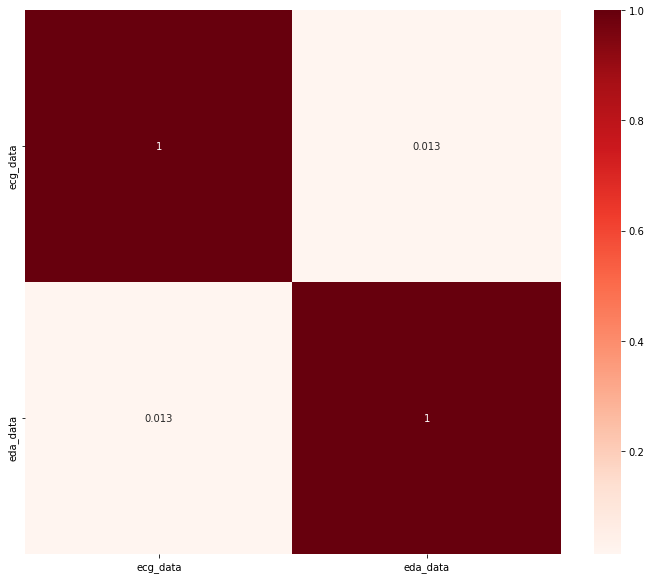

In [108]:
plt.figure(figsize=(12,10))
cor = norm_x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [109]:
X_1 = sm.add_constant(norm_x)
#Fitting sm.OLS model
model = sm.OLS(norm_y,X_1).fit()
model.pvalues

const       0.0
ecg_data    0.0
eda_data    0.0
dtype: float64

In [110]:

#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
#https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection(sfs)
sfs = SFS(QuadraticDiscriminantAnalysis(),
           k_features=2,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
sfs.fit(norm_x, norm_y)
sfs.k_feature_names_     # to get the final set of features

('ecg_data', 'eda_data')

In [111]:
display(norm_x_train)

display(norm_y_train)

,ecg_data,eda_data
4258643,-2.161573,0.042459
4006865,-0.718772,0.753934
3826082,0.450313,0.994077
1174774,0.697598,-0.988120
2373056,0.306576,-0.419104
...,...,...
3113921,1.291373,-0.407707
695853,0.171166,-1.611678
1788236,0.049514,2.421096
2471470,-1.185827,0.541468


4258643    4.0
4006865    0.0
3826082    0.0
1174774    0.0
2373056    0.0
          ... 
3113921    4.0
695853     1.0
1788236    2.0
2471470    0.0
4164107    4.0
Name: label_data, Length: 3023387, dtype: float64